In [1]:
import pandas as pd

from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt

In [2]:
seriecont = pd.read_csv("notebook_serie-contaminacion.csv", index_col="fecha",
                        parse_dates=["fecha"], date_parser=lambda d: pd.datetime.strptime(d, '%Y-%m-%d')).asfreq('d')

meteo_real = pd.read_csv("var-meteo-train.csv", index_col="date",
                        parse_dates=["date"], date_parser=lambda d: pd.datetime.strptime(d, '%Y-%m-%d')).asfreq('d')
meteo_real = meteo_real.drop("date_gen", axis=1)

meteo_pred = pd.read_csv("var-meteo-test.csv", index_col="date",
                         parse_dates=["date"], date_parser=lambda d: pd.datetime.strptime(d, '%Y-%m-%d')).asfreq('d')
meteo_pred = meteo_pred.drop("date_gen", axis=1)

seriecont = seriecont[meteo_real.index.min():meteo_pred.index.max()]

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler().fit(meteo_real)

meteo_real_scaled = scaler.transform(meteo_real)
meteo_pred_scaled = scaler.transform(meteo_pred)

pca = PCA(n_components=10).fit(meteo_real_scaled)

meteo_real_pca = pca.transform(meteo_real_scaled)
meteo_pred_pca = pca.transform(meteo_pred_scaled)

meteo_real_pca = pd.DataFrame(meteo_real_pca, index=meteo_real.index)
meteo_pred_pca = pd.DataFrame(meteo_pred_pca, index=meteo_pred.index)

In [4]:
meteo_real_pca.head()

,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2015-07-02,-0.504376,2.798512,-0.852335,-0.780081,-0.895056,-0.257762,-0.308637,0.076789,0.334893,-0.353400
2015-07-03,0.082084,3.036624,1.045996,-1.167916,-0.607475,-0.472422,0.669803,0.270863,-0.188384,-0.172179
2015-07-04,-1.604054,1.966525,0.330712,-0.998042,-0.176281,-0.312145,0.350273,0.609419,-0.170290,0.277479
2015-07-05,-1.451573,2.818816,-0.033557,-0.860587,-0.102741,-0.229093,0.357474,0.695917,-0.199327,-0.123499
2015-07-06,-1.815973,3.705881,-0.157315,-1.223369,-0.006324,-1.004604,0.717226,0.359217,-0.540903,-0.190084


In [5]:
ini_forecast = pd.Timestamp("2017-10-01", freq="D")
ndays = 7

end_forecast = ini_forecast + ndays - 1

In [6]:
forecast_daily_meteo = []
for d in range(ndays):
    ini_test = ini_forecast + d
    modelconf_day = ARIMA(seriecont[:ini_test-1], order=(1,0,1), freq="D",
                          exog = meteo_real[:ini_test-1])
    modelfit_day = modelconf_day.fit()
    forecast_daily_meteo.append(modelfit_day.forecast(1, exog=meteo_pred[ini_test:ini_test])[0])

forecast_daily_meteo = pd.DataFrame(forecast_daily_meteo, columns=["forecast"], 
                              index=seriecont[ini_forecast:end_forecast].index)

In [7]:
forecast_daily_pca = []
for d in range(ndays):
    ini_test = ini_forecast + d
    modelconf_day = ARIMA(seriecont[:ini_test-1], order=(1,0,1), freq="D",
                          exog = meteo_real_pca[:ini_test-1])
    modelfit_day = modelconf_day.fit()
    forecast_daily_pca.append(modelfit_day.forecast(1, exog=meteo_pred_pca[ini_test:ini_test])[0])

forecast_daily_pca = pd.DataFrame(forecast_daily_pca, columns=["forecast"], 
                                  index=seriecont[ini_forecast:end_forecast].index)

(70, 243.8125)

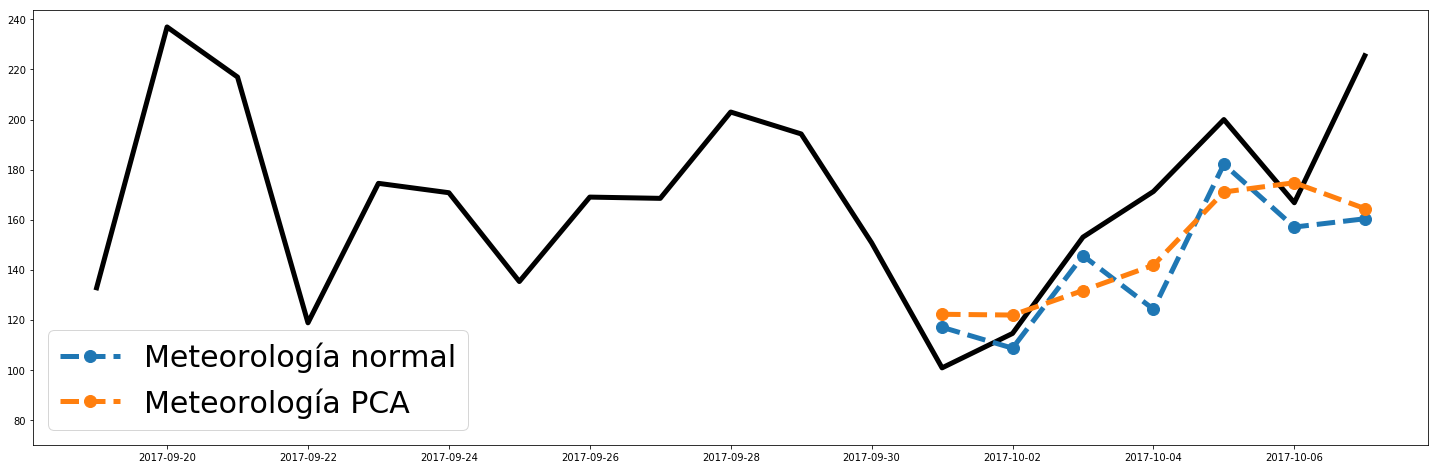

In [8]:
plt.figure(figsize=(25, 8))
plt.plot(seriecont[ini_forecast-12:end_forecast], linewidth=5, color="black")
plt.plot(forecast_daily_meteo, linewidth=5, linestyle="--", markersize=12, marker='o', label="Meteorología normal")
plt.plot(forecast_daily_pca, linewidth=5, linestyle="--", markersize=12, marker='o', label="Meteorología PCA")
plt.legend(prop={'size': 30})
plt.ylim(bottom=70)